In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import math
import xpress  as xp

Using the Community license in this session. If you have a full Xpress license, first set the XPAUTH_PATH environment variable to the full path to your license file, xpauth.xpr, and then restart Python. If you want to use the FICO Community license and no longer want to see this message, set the XPAUTH_PATH environment variable to: /home/andrea/anaconda3/lib/python3.9/site-packages/xpress/license/community-xpauth.xpr
NB: setting XPAUTH_PATH will also affect any other Xpress products installed on your system.


In [2]:
# input
C = 15
L = 3

custom_setup = False
map_size = 100
ratio_locker_customers = 0.3
ratio_prime_door_to_door_customer = 0.4

In [4]:
# define the locations of customers and lockers and warehouse
if custom_setup:
    C_location = np.array([[0.1 ,0.28], [0.2 ,0.4],[0.15 ,0.7], [0.3 ,0.7],[0.8 ,0.6],[0.7 ,0.4],[0.9 ,0.5], [0.4, 0.15]])
    W_location = np.array([[0.6 ,0.5]])
    L_location = np.array([[0.3 ,0.5],[0.5,0.2]])
else:
    C_location = np.random.randint(map_size, size=(C, 2))
    W_location = np.random.randint(map_size, size=(1, 2))
    L_location = np.random.randint(map_size, size=(L, 2))
stores_location = np.concatenate((W_location, L_location), axis=0)

In [5]:
def euclidean_distance(location_a, location_b):
    if len(location_a) != 2 or len(location_b) != 2:
        raise Exception("the two location need to be a list each of size 2")
    delta_x = location_b[0]-location_a[0]
    delta_y = location_b[1]-location_a[1]
    return math.sqrt(delta_x*delta_x+delta_y*delta_y)

def find_nearest_stores_from_customer(customer_location, stores_location_par):
    min_distance = float("inf")
    nearest_store_location = []
    index = 0
    nearest_locker_index = -1
    for store_location in stores_location_par:
        distance = euclidean_distance(customer_location, store_location)
        if distance < min_distance:
            min_distance = distance
            nearest_store_location = store_location
            nearest_locker_index = index
        index +=1
    return nearest_locker_index, nearest_store_location


In [6]:
# Customers’ demand and preferences
q = np.ones(C)

# define all the stores: eg. stores = [W, L0, L1, .... , Lx]
warehouse = ["W"]
lockers = []
for l in range(L):
    lockers.append("L"+str(l))
stores = warehouse+lockers

if custom_setup:
    C_L = [0, 5, 7]
    C_D = [1, 2, 3, 4, 6]
    S_k =[1, 2, 6]
    a_k = ["L0", "W", "L1"]
else:
    C_L = []
    C_D = []
    S_k = []
    a_k = []
    for client in range(C):
        if random.random()  <= ratio_locker_customers :
            # locker customer
            C_L.append(client)
            a_k.append(random.choice(stores)) # TODO assign not a random store but the one that in most case is the nearest to the customer
        else:
            # door to door customer
            C_D.append(client)
            if random.random() >= ratio_prime_door_to_door_customer:
                S_k.append(client)


In [7]:
# Capacities

# PF vehicles capacities
Q = math.ceil(0.5 * len(C_D))
# locker storage (every locker has the same capacity by default)
W_l = []
for i in range(L):
    W_l.append(math.ceil(0.8 * C / L))
# LF vehicles capacities (every LF vehicle has the same capacity by default)
Q_l = []
for i in range(L):
    Q_l.append(math.ceil(0.6 * W_l[i]))

sum_W_l = 0
for i in range(len(W_l)):
    sum_W_l += W_l[i]


# supply vehicles storage
Q_L = math.ceil(0.8 * sum_W_l)

print("Q: ",Q)
print("W_l: ",W_l)
print("Q_l: ",Q_l)
print("Q_L: ",Q_L)
print("sum_W_l: ", sum_W_l)


Q:  4
W_l:  [4, 4, 4]
Q_l:  [3, 3, 3]
Q_L:  10
sum_W_l:  12


['Cl0', 'Cl1', 'Cl2', 'Cl3', 'Cl4', 'Cl5', 'Cl6']
['Cd0', 'Cd1', 'Cd2', 'Cd3', 'Cd4', 'Cd5', 'Cd6', 'Cd7']
['Cd0', 'Cd1', 'Cd2', 'Cd3', 'Cd4', 'Cd5', 'Cd6', 'Cd7', 'Cl0', 'Cl1', 'Cl2', 'Cl3', 'Cl4', 'Cl5', 'Cl6']


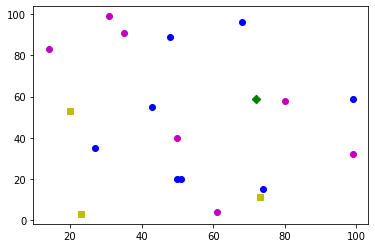

In [8]:
CD_location = np.array([[0,0]])
CL_location = np.array([[0,0]])

for i in range(C):
    if i in  C_D:
        CD_location=np.vstack([CD_location, C_location[i]])
    else:
        CL_location = np.vstack([CL_location, C_location[i]])

CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)

#define all customers
Customers = []
Customers_door = []
Customers_locker = []
for c in range(len(C_D)):
    Customers_door.append("Cd"+str(c))
for c in range(len(C_L)):
    Customers_locker.append("Cl"+str(c))

Customers = Customers_door+Customers_locker

print(Customers_locker)
print(Customers_door)
print(Customers)

plt.scatter(CD_location[:,0],CD_location[:,1],color='b')
plt.scatter(CL_location[:,0],CL_location[:,1],color='m')
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')

#piccola nota
#come nel paper in verde è la warehouse, in giallo i locker, mentre in blu in customer door to door e in magenta i customer locker

In [9]:
#calcolo la matrice delle distanze:
all_locations = np.array([])
all_locations = np.append(all_locations,W_location)
all_locations = np.vstack([all_locations,L_location])
all_locations = np.vstack([all_locations,CD_location])
all_locations = np.vstack([all_locations,CL_location])

all_buildings = stores + Customers

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()
print(dist_matrix)

             W         L0          L1         L2        Cd0        Cd1  \
W     0.000000  52.345009   74.411021  48.010416  44.294469  44.045431   
L0   52.345009   0.000000   50.089919  67.623960  45.276926  66.030296   
L1   74.411021  50.089919    0.000000  50.635956  32.756679  52.392748   
L2   48.010416  67.623960   50.635956   0.000000  23.769729   4.123106   
Cd0  44.294469  45.276926   32.756679  23.769729   0.000000  23.537205   
Cd1  44.045431  66.030296   52.392748   4.123106  23.537205   0.000000   
Cd2  51.000000  19.313208   32.249031  51.884487  28.301943  51.078371   
Cd3  38.418745  45.607017   89.560036  81.908486  69.065187  78.434686   
Cd4  27.000000  79.227520   94.403390  54.589376  61.846584  50.606324   
Cd5  44.777226  44.598206   31.906112  24.698178   1.000000  24.515301   
Cd6  37.215588  64.443774  103.315052  85.146932  77.878110  81.221918   
Cd7  29.274562  23.086793   55.713553  53.254108  35.902646  50.606324   
Cl0  38.183766  81.743501   81.344945 

In [10]:
#filter data

supply_distances_matrix = dist_matrix.filter(items=stores,axis=1)
supply_distances_matrix  = supply_distances_matrix.filter(items=stores,axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=['W']+Customers_door,axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=['W']+Customers_door,axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=lockers+Customers_door,axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers+Customers_door,axis=0)
print(LF_distances_matrix)

            W         L0         L1         L2
W    0.000000  52.345009  74.411021  48.010416
L0  52.345009   0.000000  50.089919  67.623960
L1  74.411021  50.089919   0.000000  50.635956
L2  48.010416  67.623960  50.635956   0.000000
             W        Cd0        Cd1        Cd2        Cd3        Cd4  \
W     0.000000  44.294469  44.045431  51.000000  38.418745  27.000000   
Cd0  44.294469   0.000000  23.537205  28.301943  69.065187  61.846584   
Cd1  44.045431  23.537205   0.000000  51.078371  78.434686  50.606324   
Cd2  51.000000  28.301943  51.078371   0.000000  57.939624  75.894664   
Cd3  38.418745  69.065187  78.434686  57.939624   0.000000  59.169249   
Cd4  27.000000  61.846584  50.606324  75.894664  59.169249   0.000000   
Cd5  44.777226   1.000000  24.515301  27.459060  69.028979  62.625873   
Cd6  37.215588  77.878110  81.221918  73.498299  21.189620  48.270074   
Cd7  29.274562  35.902646  50.606324  25.612497  34.365681  56.142675   

           Cd5        Cd6        C

In [11]:
#calcolo la matrice delle distanze:
all_locations = np.array([])
all_locations = np.append(all_locations,W_location)
all_locations = np.vstack([all_locations,L_location])
all_locations = np.vstack([all_locations,CD_location])
all_locations = np.vstack([all_locations,CL_location])

all_buildings = stores + Customers

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()
print(dist_matrix)

             W         L0          L1         L2        Cd0        Cd1  \
W     0.000000  52.345009   74.411021  48.010416  44.294469  44.045431   
L0   52.345009   0.000000   50.089919  67.623960  45.276926  66.030296   
L1   74.411021  50.089919    0.000000  50.635956  32.756679  52.392748   
L2   48.010416  67.623960   50.635956   0.000000  23.769729   4.123106   
Cd0  44.294469  45.276926   32.756679  23.769729   0.000000  23.537205   
Cd1  44.045431  66.030296   52.392748   4.123106  23.537205   0.000000   
Cd2  51.000000  19.313208   32.249031  51.884487  28.301943  51.078371   
Cd3  38.418745  45.607017   89.560036  81.908486  69.065187  78.434686   
Cd4  27.000000  79.227520   94.403390  54.589376  61.846584  50.606324   
Cd5  44.777226  44.598206   31.906112  24.698178   1.000000  24.515301   
Cd6  37.215588  64.443774  103.315052  85.146932  77.878110  81.221918   
Cd7  29.274562  23.086793   55.713553  53.254108  35.902646  50.606324   
Cl0  38.183766  81.743501   81.344945 

In [12]:
#filter data

supply_distances_matrix = dist_matrix.filter(items=stores,axis=1)
supply_distances_matrix  = supply_distances_matrix.filter(items=stores,axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=['W']+Customers_door,axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=['W']+Customers_door,axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=lockers+Customers_door,axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers+Customers_door,axis=0)
print(LF_distances_matrix)

            W         L0         L1         L2
W    0.000000  52.345009  74.411021  48.010416
L0  52.345009   0.000000  50.089919  67.623960
L1  74.411021  50.089919   0.000000  50.635956
L2  48.010416  67.623960  50.635956   0.000000
             W        Cd0        Cd1        Cd2        Cd3        Cd4  \
W     0.000000  44.294469  44.045431  51.000000  38.418745  27.000000   
Cd0  44.294469   0.000000  23.537205  28.301943  69.065187  61.846584   
Cd1  44.045431  23.537205   0.000000  51.078371  78.434686  50.606324   
Cd2  51.000000  28.301943  51.078371   0.000000  57.939624  75.894664   
Cd3  38.418745  69.065187  78.434686  57.939624   0.000000  59.169249   
Cd4  27.000000  61.846584  50.606324  75.894664  59.169249   0.000000   
Cd5  44.777226   1.000000  24.515301  27.459060  69.028979  62.625873   
Cd6  37.215588  77.878110  81.221918  73.498299  21.189620  48.270074   
Cd7  29.274562  35.902646  50.606324  25.612497  34.365681  56.142675   

           Cd5        Cd6        C

In [13]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*PF_distances_matrix
LF_delivery_cost = pi_l*LF_distances_matrix
supply_cost = pi_L*supply_distances_matrix
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)

            W         L0         L1         L2
W    0.000000  39.258757  55.808266  36.007812
L0  39.258757   0.000000  37.567439  50.717970
L1  55.808266  37.567439   0.000000  37.976967
L2  36.007812  50.717970  37.976967   0.000000
             W        Cd0        Cd1        Cd2        Cd3        Cd4  \
W     0.000000  44.294469  44.045431  51.000000  38.418745  27.000000   
Cd0  44.294469   0.000000  23.537205  28.301943  69.065187  61.846584   
Cd1  44.045431  23.537205   0.000000  51.078371  78.434686  50.606324   
Cd2  51.000000  28.301943  51.078371   0.000000  57.939624  75.894664   
Cd3  38.418745  69.065187  78.434686  57.939624   0.000000  59.169249   
Cd4  27.000000  61.846584  50.606324  75.894664  59.169249   0.000000   
Cd5  44.777226   1.000000  24.515301  27.459060  69.028979  62.625873   
Cd6  37.215588  77.878110  81.221918  73.498299  21.189620  48.270074   
Cd7  29.274562  35.902646  50.606324  25.612497  34.365681  56.142675   

           Cd5        Cd6        C

In [14]:
#filter data

supply_distances_matrix = dist_matrix.filter(items=stores,axis=1)
supply_distances_matrix  = supply_distances_matrix.filter(items=stores,axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=['W']+Customers_door,axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=['W']+Customers_door,axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=lockers+Customers_door,axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers+Customers_door,axis=0)
print(LF_distances_matrix)

            W         L0         L1         L2
W    0.000000  52.345009  74.411021  48.010416
L0  52.345009   0.000000  50.089919  67.623960
L1  74.411021  50.089919   0.000000  50.635956
L2  48.010416  67.623960  50.635956   0.000000
             W        Cd0        Cd1        Cd2        Cd3        Cd4  \
W     0.000000  44.294469  44.045431  51.000000  38.418745  27.000000   
Cd0  44.294469   0.000000  23.537205  28.301943  69.065187  61.846584   
Cd1  44.045431  23.537205   0.000000  51.078371  78.434686  50.606324   
Cd2  51.000000  28.301943  51.078371   0.000000  57.939624  75.894664   
Cd3  38.418745  69.065187  78.434686  57.939624   0.000000  59.169249   
Cd4  27.000000  61.846584  50.606324  75.894664  59.169249   0.000000   
Cd5  44.777226   1.000000  24.515301  27.459060  69.028979  62.625873   
Cd6  37.215588  77.878110  81.221918  73.498299  21.189620  48.270074   
Cd7  29.274562  35.902646  50.606324  25.612497  34.365681  56.142675   

           Cd5        Cd6        C

In [15]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*PF_distances_matrix
LF_delivery_cost = pi_l*LF_distances_matrix
supply_cost = pi_L*supply_distances_matrix
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)

            W         L0         L1         L2
W    0.000000  39.258757  55.808266  36.007812
L0  39.258757   0.000000  37.567439  50.717970
L1  55.808266  37.567439   0.000000  37.976967
L2  36.007812  50.717970  37.976967   0.000000
             W        Cd0        Cd1        Cd2        Cd3        Cd4  \
W     0.000000  44.294469  44.045431  51.000000  38.418745  27.000000   
Cd0  44.294469   0.000000  23.537205  28.301943  69.065187  61.846584   
Cd1  44.045431  23.537205   0.000000  51.078371  78.434686  50.606324   
Cd2  51.000000  28.301943  51.078371   0.000000  57.939624  75.894664   
Cd3  38.418745  69.065187  78.434686  57.939624   0.000000  59.169249   
Cd4  27.000000  61.846584  50.606324  75.894664  59.169249   0.000000   
Cd5  44.777226   1.000000  24.515301  27.459060  69.028979  62.625873   
Cd6  37.215588  77.878110  81.221918  73.498299  21.189620  48.270074   
Cd7  29.274562  35.902646  50.606324  25.612497  34.365681  56.142675   

           Cd5        Cd6        C

## extra code to delete

In [ ]:
x = np.random.randint(0, 50, 7)
y = np.random.randint(0, 50, 7)
C = [x,y]
plt.scatter(C[0],C[1])
C = np.arange(7)
print(C)
plt.show()

In [ ]:
C = np.random.rand(7,2)
plt.scatter(C[:,0],C[:,1],color='b')
W = np.random.rand(1,2)
plt.scatter(W[:,0],W[:,1],color='g',marker='D')
L = np.random.rand(1,2)
plt.scatter(L[:,0],L[:,1],color ='y',marker='s')
print(C)

In [ ]:
C = np.array([[0.1 ,0.1], [0.2 ,0.3],[0.15 ,0.7], [0.3 ,0.7],[0.8 ,0.6],
              [0.9 ,0.5],[0.7 ,0.3]])
plt.scatter(C[:,0],C[:,1],color='b')
W = np.array([[0.6 ,0.5]])
plt.scatter(W[:,0],W[:,1],color='g',marker='D')
L = np.array([[0.3 ,0.5]])
plt.scatter(L[:,0],L[:,1],color ='y',marker='s')

In [ ]:
#calcolo la matrice delle distanze:
data = np.array([])
data = np.append(data,W)
data = np.vstack([data,L])
data = np.vstack([data,C])
buildings =['Warehouse','Locker','c1','c2','c3','c4','c5','c6','c7']
print(len(data))
df = pd.DataFrame(data, columns=['xcord', 'ycord'], index=buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()

In [ ]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
LF_delivery_cost = pi_l*matrix_distance_converted_in_numpy
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
Suplly_cost = pi_L*matrix_distance_converted_in_numpy


In [30]:
print("andrea")


andrea


In [ ]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
LF_delivery_cost = pi_l*matrix_distance_converted_in_numpy
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
Suplly_cost = pi_L*matrix_distance_converted_in_numpy
